In [1]:
import os
import math
import shutil
import numpy as np
import pandas as pd

from pathlib import Path
from tqdm.notebook import tqdm, trange

import cmaps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmaps
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.ticker import NullFormatter, FixedLocator, FormatStrFormatter, MultipleLocator, PercentFormatter, FuncFormatter
import matplotlib.ticker as mticker

import xarray as xr

In [2]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
version = "daily_100"

Merge_data_path = Path("/data6t/AIWP_TP_dataset/merge_data")
Merge_daily_all_data_path = Merge_data_path / version
Durre_data_path = Path("/data6t/AIWP_TP_dataset/Durre2010_data")
Durre_daily_all_data_path = Durre_data_path / version

Hamada_data_path = Path("/data6t/AIWP_TP_dataset/Hamada2011_data")
Hamada_daily_all_data_path = Hamada_data_path / version

Beck_data_path = Path("/data6t/AIWP_TP_dataset/Beck2019_data")
Beck_daily_all_data_path = Beck_data_path / version

QC_data_path = Path("/data6t/AIWP_TP_dataset/QC_data")
QC_daily_data_path = QC_data_path / version

In [4]:
BENCHMARK_DIR = Path("/data6t/AIWP_TP_dataset/benchmark")

In [5]:
QC_data_path = Path("/data6t/AIWP_TP_dataset/QC_data")
QC_daily_data_path = QC_data_path / "daily"

ERA5_daily_tp_path = BENCHMARK_DIR / "ERA5_tp_24h_rolling.zarr"

In [6]:
QC_daily_tp = xr.open_dataset("Raw_QC_PRCP_by_station.nc").load()
QC_daily_tp

<xarray.Dataset> Size: 390MB
Dimensions:         (station: 22212, time: 2192)
Coordinates:
  * station         (station) int64 178kB 0 1 2 3 4 ... 22208 22209 22210 22211
  * time            (time) datetime64[ns] 18kB 2020-01-01 ... 2025-12-31
    latitude        (station) float64 178kB 90.0 82.5 81.25 ... -77.75 -78.0
    longitude       (station) float64 178kB 359.8 297.8 268.2 ... 325.5 166.8
    reporting_time  (station) float64 178kB -14.0 0.0 -1.0 -2.0 ... 4.0 12.0 7.0
Data variables:
    PRCP_mean       (station, time) float32 195MB 4.0 2.7 nan ... nan nan nan
    PRCP_raw        (station, time) float32 195MB 4.0 2.7 nan ... nan nan nan

In [ ]:
from scipy.stats import spearmanr, pearsonr

def calc_station_metrics(args):
    station_tp, bench_name = args
    bench_path_dict = {"IMERG": "IMERG_V07_Late_24h_rolling.zarr",
                       "MSWEP": "MSWEP_V280_24h_rolling.zarr",
                       "GPCC": "GPCC_first_guess_daily_2020_2024.nc",
                       "ERA5": "ERA5_tp_24h_rolling.zarr"}
    bench_var_dict = {"IMERG": "precipitation",
                       "MSWEP": "precipitation",
                       "GPCC": "p",
                       "ERA5": "tp"}
    bench_tp_path = BENCHMARK_DIR / bench_path_dict[bench_name]
    bench_var = bench_var_dict[bench_name]
                       
    station_tp = station_tp.load().dropna(dim="time", how="all")
    
    station_id = station_tp.station.item()
    lat, lon = station_tp.latitude.item(), station_tp.longitude.item()
    era5_shift_hour = station_tp.reporting_time.item()
    era5_shift_hour = int(era5_shift_hour) if not math.isnan(era5_shift_hour) else 0
    
    if bench_name in ["GPCC", "IMERG", "MSWEP"]:
        lon = lon if lon <= 180 else lon - 360
    
    original_station_date = station_tp.time.data + np.timedelta64(24, 'h') 
    correct_station_date = station_tp.time.data + np.timedelta64(24-era5_shift_hour, 'h')
    

    if bench_name == "GPCC":
        station_bench_tp = xr.open_dataset(bench_tp_path)[bench_var].sel(
            lat=lat, lon=lon, time=original_station_date, method="nearest").load()
        station_bench_tp_c = xr.open_dataset(bench_tp_path)[bench_var].sel(
            lat=lat, lon=lon, time=correct_station_date, method="nearest").load()        
    else:
        station_bench_tp = xr.open_zarr(bench_tp_path)[bench_var].sel(
            lat=lat, lon=lon, time=original_station_date, method="nearest").load()
        station_bench_tp_c = xr.open_zarr(bench_tp_path)[bench_var].sel(
            lat=lat, lon=lon, time=correct_station_date, method="nearest").load()
    station_corrs = {"station": station_id}


    qc_data = station_tp["PRCP_mean"].data
    raw_data = station_tp["PRCP_raw"].data
    bench_data = station_bench_tp.data
    bench_data_c = station_bench_tp_c.data
    
    valid_mask = ~np.isnan(raw_data) & ~np.isnan(bench_data)
    valid_mask_c = ~np.isnan(raw_data) & ~np.isnan(bench_data_c)
    
    valid_mask_qc = ~np.isnan(qc_data) & ~np.isnan(bench_data)
    valid_mask_qc_c = ~np.isnan(qc_data) & ~np.isnan(bench_data_c)
    
    if (valid_mask.sum() < 30) or (valid_mask_qc.sum() < 30):
        return None

    else:
        raw_data, bench_data_raw, bench_data_raw_c = raw_data[valid_mask], bench_data[valid_mask], bench_data_c[valid_mask]
        qc_data, bench_data_qc, bench_data_qc_c = qc_data[valid_mask_qc], bench_data[valid_mask_qc], bench_data_c[valid_mask_qc_c]
        
        qc_pearson, _ = pearsonr(qc_data, bench_data_qc)
        raw_pearson, _ = pearsonr(raw_data, bench_data_raw)
        qc_spearman, _ = spearmanr(qc_data, bench_data_qc)
        raw_spearman, _ = spearmanr(raw_data, bench_data_raw)

        qc_pearson_c, _ = pearsonr(qc_data, bench_data_qc_c)
        raw_pearson_c, _ = pearsonr(raw_data, bench_data_raw_c)
        qc_spearman_c, _ = spearmanr(qc_data, bench_data_qc_c)
        raw_spearman_c, _ = spearmanr(raw_data, bench_data_raw_c)

        station_corrs["LONGITUDE"] = lon
        station_corrs["LATITUDE"] = lat
        
        station_corrs["qc_pearson"] = qc_pearson
        station_corrs["raw_pearson"] = raw_pearson
        station_corrs["qc_spearman"] = qc_spearman
        station_corrs["raw_spearman"] = raw_spearman
        
        station_corrs["qc_pearson_c"] = qc_pearson_c
        station_corrs["raw_pearson_c"] = raw_pearson_c
        station_corrs["qc_spearman_c"] = qc_spearman_c
        station_corrs["raw_spearman_c"] = raw_spearman_c        
        
        
        return station_corrs

In [ ]:
import multiprocessing as mp
from multiprocessing import Pool, Manager


args_list = [
    (QC_daily_tp[["PRCP_mean", "PRCP_raw"]].sel(station=station_id), "MSWEP") 
    for station_id in QC_daily_tp.station.data
]

with Pool(mp.cpu_count()) as pool:
    results = list(tqdm(
        pool.imap_unordered(calc_station_metrics, args_list),
        total=len(QC_daily_tp.station.data),
        desc="Processing progress"
    ))
MSWEP_results = pd.DataFrame([res for res in results if res is not None])
MSWEP_results.to_csv("Corr_raw_qc_shift_mswep_2025.csv", index=None)
MSWEP_results

处理进度:   0%|          | 0/22212 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
import multiprocessing as mp
from multiprocessing import Pool, Manager


args_list = [
    (QC_daily_tp[["PRCP_mean", "PRCP_raw"]].sel(station=station_id), "IMERG") 
    for station_id in QC_daily_tp.station.data
]

with Pool(mp.cpu_count()) as pool:
    results = list(tqdm(
        pool.imap_unordered(calc_station_metrics, args_list),
        total=len(QC_daily_tp.station.data),
        desc="Processing progress"
    ))
IMERG_results = pd.DataFrame([res for res in results if res is not None])
IMERG_results.to_csv("Corr_raw_qc_shift_imerg_2025.csv", index=None)
IMERG_results

处理进度:   0%|          | 0/22212 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
import multiprocessing as mp
from multiprocessing import Pool, Manager


args_list = [
    (QC_daily_tp[["PRCP_mean", "PRCP_raw"]].sel(station=station_id), "ERA5") 
    for station_id in QC_daily_tp.station.data
]

with Pool(mp.cpu_count()) as pool:
    results = list(tqdm(
        pool.imap_unordered(calc_station_metrics, args_list),
        total=len(QC_daily_tp.station.data),
        desc="Processing progress"
    ))
ERA5_results = pd.DataFrame([res for res in results if res is not None])
ERA5_results.to_csv("Corr_raw_qc_shift_era5_2025.csv", index=None)
ERA5_results

# Fig.10

In [24]:
MSWEP_results = pd.read_csv("Corr_raw_qc_shift_mswep_2025.csv").rename(columns={"station": "ID"})
IMERG_results = pd.read_csv("Corr_raw_qc_shift_imerg_2025.csv").rename(columns={"station": "ID"})
ERA5_results = pd.read_csv("Corr_raw_qc_shift_era5_2025.csv").rename(columns={"station": "ID"})
# GPCC_results = pd.read_csv("Corr_raw_qc_gpcc_2025.csv").rename(columns={"station": "ID"})
MSWEP_results

,ID,LONGITUDE,LATITUDE,qc_pearson,raw_pearson,qc_spearman,raw_spearman,qc_pearson_c,raw_pearson_c,qc_spearman_c,raw_spearman_c
0,21,137.75,76.00,0.236918,0.149860,0.533510,0.538682,0.745474,0.575909,0.643108,0.644412
1,3,58.00,80.50,0.613375,0.613375,0.671605,0.671605,0.623630,0.623630,0.695843,0.695843
2,17,-83.00,76.50,0.763533,0.763533,0.639973,0.639973,0.763533,0.763533,0.639973,0.639973
3,23,-105.75,75.50,0.326152,0.236172,0.437688,0.434968,0.326152,0.236172,0.437688,0.434968
4,7,12.00,79.00,0.390682,0.281035,0.615652,0.614079,0.398177,0.286897,0.599944,0.598468
...,...,...,...,...,...,...,...,...,...,...,...
21923,22211,166.75,-78.00,0.261817,0.208429,0.208979,0.240558,0.288707,0.233826,0.230984,0.267869
21924,22208,2.50,-72.00,0.529805,0.529805,0.514461,0.514461,0.553581,0.553581,0.546965,0.546965
21925,22207,11.75,-70.75,0.269951,0.099310,0.590603,0.591284,0.290426,0.106348,0.607994,0.608668
21926,22199,-56.75,-64.25,0.477793,0.477793,0.376075,0.376075,0.592580,0.592580,0.461169,0.461169


In [28]:
from scipy.stats import gaussian_kde, pearsonr, norm, spearmanr

       qc_pearson_c   raw_pearson
count  21668.000000  21679.000000
mean       0.582340      0.435576
std        0.152456      0.177908
min       -0.201285     -0.269762
25%        0.509169      0.329596
50%        0.616948      0.456635
75%        0.690180      0.560550
max        0.999827      0.999827
       qc_pearson_c   raw_pearson
count  21669.000000  21680.000000
mean       0.667663      0.516253
std        0.158287      0.187938
min       -0.174505     -0.159469
25%        0.598083      0.407033
50%        0.706733      0.540164
75%        0.776077      0.648281
max        0.994426      0.989220
       qc_pearson_c   raw_pearson
count  21669.000000  21680.000000
mean       0.602834      0.471052
std        0.155958      0.173366
min       -0.213315     -0.164605
25%        0.519744      0.364997
50%        0.630383      0.480280
75%        0.712870      0.590368
max        0.994870      0.983498


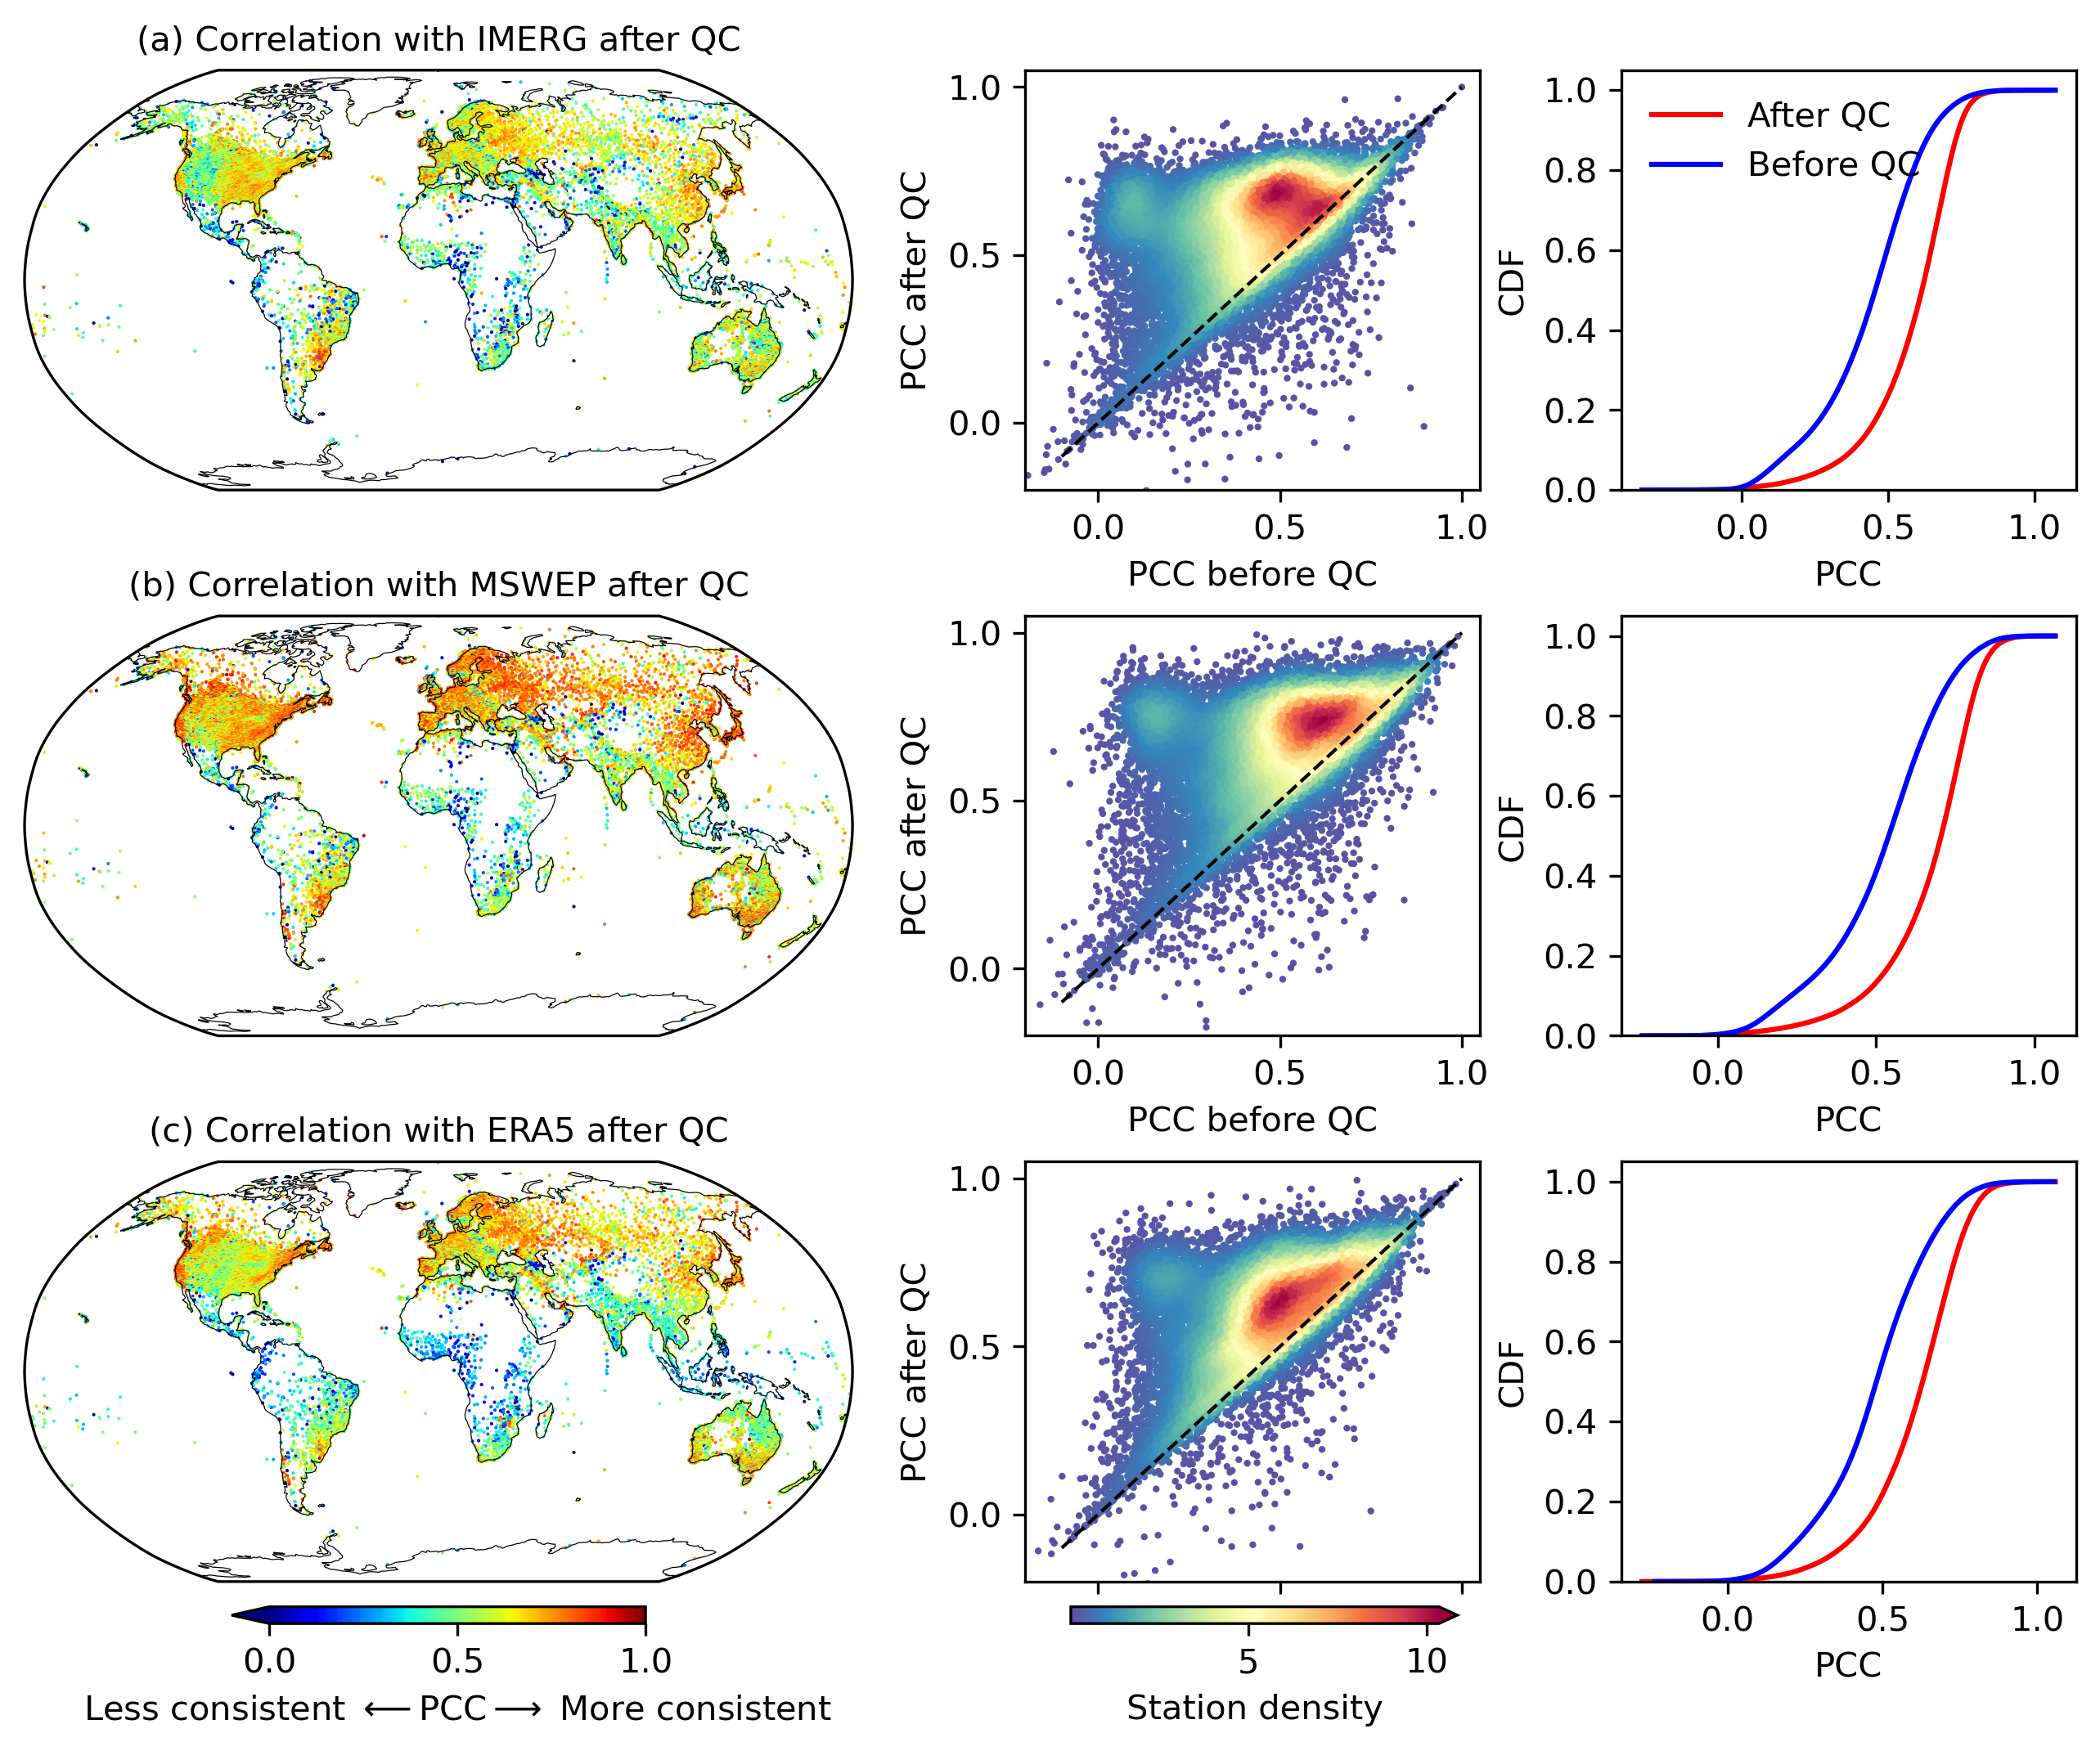

In [30]:
lon_center = 0
fs = 10
map_proj = ccrs.Robinson(central_longitude=lon_center)
# map_proj = ccrs.PlateCarree(central_longitude=lon_center)
data_proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(11, 8), dpi=300)
grids = plt.GridSpec(3, 5, wspace=0.1, hspace=0.3, width_ratios=[1, 0.06, 0.5, 0.07, 0.5])

for i, (bench_name, plot_data) in enumerate([("IMERG", IMERG_results),
                                             ("MSWEP", MSWEP_results),  
                                             ("ERA5", ERA5_results)]):

    ax1 = fig.add_subplot(grids[i, 0], projection=map_proj)

    ax1.coastlines(linewidth=0.3)
    ax1.set_title(f"({chr(97+i)}) Correlation with {bench_name} after QC", fontsize=fs)
    # plot_data = plot_data.sort_values("qc_pearson", ascending=False)
    plot = ax1.scatter(plot_data["LONGITUDE"], plot_data["LATITUDE"], c=plot_data["qc_pearson_c"], 
                    transform=data_proj, cmap=cmaps.MPL_jet, #cmaps.MPL_RdBu_r,
                    s=1, edgecolor='None', vmin=0, vmax=1, label='QC Data')


    ax2 = fig.add_subplot(grids[i, 2])

    x = plot_data["raw_pearson"].values
    y = plot_data["qc_pearson_c"].values
    nona_mask = (~np.isnan(x)) & (~np.isnan(y))
    x = x[nona_mask]
    y = y[nona_mask]

    scatter_xy = np.vstack([x,y])
    scatter_z = gaussian_kde(scatter_xy)(scatter_xy) # * len(x)
    scatter_z = scatter_z.clip(max=14)
    # ax4.scatter(rmse_e1[ELEMENT].data, rmse_e3[ELEMENT].data, s=2, color='k', alpha=0.5)
    density_scatter = ax2.scatter(x, y, marker='o', s=1, c=scatter_z, cmap='Spectral_r')
    ax2.set_xlim([-0.2, 1.05])
    ax2.set_ylim([-0.2, 1.05])
    ax2.plot([-0.1,1], [-0.1,1], color="black", linestyle="--", lw=1)

    ax2.set_xticks([0.0, 0.5, 1.0])
    ax2.set_yticks([0.0, 0.5, 1.0])
    ax2.set_xlabel("PCC before QC") if i < 2 else ax2.set_xticklabels([])
    ax2.set_ylabel("PCC after QC")

    ax3 = fig.add_subplot(grids[i, 4])
    # ax3 = fig.add_subplot(grids[i, 2])
    print(plot_data[["qc_pearson_c","raw_pearson"]].describe())
    sns.kdeplot(plot_data["qc_pearson_c"], cumulative=True,label="After QC", color="red", ax=ax3)
    sns.kdeplot(plot_data["raw_pearson"], cumulative=True,label="Before QC", color="blue", ax=ax3)
    ax3.set_xlabel("PCC")
    ax3.set_ylabel("CDF")
    if i ==0: ax3.legend(frameon=False, fontsize=fs)

cbar_ax = ax1.inset_axes(bounds=[0.25, -0.1, 0.5, 0.04], transform=ax1.transAxes)
cbar = fig.colorbar(plot, cax=cbar_ax, orientation='horizontal', shrink=0.9, pad=.09, 
                    extend="min", extendfrac=0.1)
cbar.ax.set_xlabel(r"Less consistent $\mathrm{\longleftarrow PCC \longrightarrow}$ More consistent", fontsize=fs)

# ax2.set_xlabel("PCC before QC")
ax3.set_xlabel("PCC")


cbar_ax = ax2.inset_axes(bounds=[0.1, -0.1, 0.85, 0.04], transform=ax2.transAxes)
cbar = fig.colorbar(density_scatter,cax=cbar_ax, orientation='horizontal', shrink=0.9, pad=.09,extend="max")
# cbar.ax.tick_params(labelsize=fs-2,direction="in")
# cbar.ax.tick_params(which="minor",direction="in")
# cbar.ax.set_xticks([0, 100, 200])
cbar.ax.set_xlabel("Station density", fontsize=fs)

fig.savefig("figures/Figure 11.jpg", dpi=300, bbox_inches="tight")